In [37]:
#import dependancies
#major portions of code taken from https://www.kaggle.com/code/chayan8/sentiment-analysis-using-bert-pytorch
import numpy as np 
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

!pip install transformers
from transformers import AdamW,BertTokenizer, get_linear_schedule_with_warmup, BertForSequenceClassification
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#load data from link
rawData = pd.read_csv('https://raw.githubusercontent.com/Pulsy1577/Deep-Learning-Project/main/hogwarts_legacy_reviews.csv')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:

# define data and class labels
numpyData = rawData.to_numpy()
text_tot = numpyData[:,3]
labels_tot = numpyData[:,2]
index_tot = numpyData[:,0]


# create Pandas DataFrame
all_data = pd.DataFrame({'index': index_tot, 'text': text_tot, 'Labels': labels_tot})

all_labels = []
all_text = []
all_index = []
#changing text labels to integer values, and create arrays for positive and negative reviews
#will need to update if uing diffirent classes
for i in range(len(all_data.Labels)):
  if(all_data["Labels"][i] == "Positive"):
    all_data["Labels"][i] = "0"

    all_index.append(all_data["index"][i])
    all_text.append(all_data["text"][i])
    all_labels.append(all_data["Labels"][i])
     
  if(all_data["Labels"][i] == "Negative"):
    all_data["Labels"][i] = "1"
    #add in the negative reviews more than once to balance data set
    for j in range (3):
      all_index.append(all_data["index"][i])
      all_text.append(all_data["text"][i])
      all_labels.append(all_data["Labels"][i])

#more dataframes
all_data = pd.DataFrame({'index': all_index, 'text': all_text, 'Labels': all_labels})

#train val test split
X_train, X_val, y_train, y_val = train_test_split(all_data.index.values, 
                                                  all_data.Labels.values, 
                                                  test_size=0.15, 
                                                  random_state=42,
                                                  stratify=all_data.Labels.values)


In [4]:
#adding labels to the dataframe
all_data['data_type'] = ['not_set']*all_data.shape[0]

all_data.loc[X_train, 'data_type'] = 'train'
all_data.loc[X_val, 'data_type'] = 'val'

In [5]:

#importing tokeneizer
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)



In [6]:
#extract the train set to use
all_strings = all_data[all_data.data_type =='train'].text.values
all_labels = all_data[all_data.data_type =='train'].Labels.values

arr = []
label_arr = []
#extract raw data from our train and test sets
for i in range(len(all_strings)):
    temp = all_strings[i]
    arr.append(temp)

for i in range(len(all_labels)):
    temp = all_labels[i]
    label_arr.append(int(temp))

#err data betwen 12000-14000
#split the data once again into a train and test set, but encode the data, both sets 12000 elements
temp_len_train = 12000
encoded_data_val = tokenizer.batch_encode_plus(
    arr[0:temp_len_train],
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


start_val = 14000
encoded_data_train = tokenizer.batch_encode_plus(
    arr[start_val:start_val+temp_len_train],
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


#extract the features from our encoded datasets, then put them into a tensor
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(label_arr[start_val:start_val+temp_len_train])

input_ids_val = encoded_data_val['input_ids']
input_ids_val = input_ids_val[0:temp_len_train]
attention_masks_val = encoded_data_val['attention_mask']
attention_masks_val = attention_masks_val[0:temp_len_train]
labels_val = torch.tensor(label_arr[0:temp_len_train])



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [7]:
#send all data to GPU
input_ids_train.to(device)
attention_masks_train.to(device)
labels_train.to(device)

input_ids_val.to(device)
attention_masks_val.to(device)
labels_val.to(device)
#create tensors
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

dataset_test = TensorDataset(input_ids_val, 
                              attention_masks_val,
                              labels_val)

#create dataloaders
dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=32
)

dataloader_test = DataLoader(
    dataset_test,
    sampler=RandomSampler(dataset_train),
    batch_size=32
)



In [8]:

#load in model
model = BertForSequenceClassification.from_pretrained(
                                      'bert-base-uncased', 
                                      num_labels = 2,
                                      output_attentions = False,
                                      output_hidden_states = False
                                     )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [9]:
model.to(device)

#evaluation loop
def evaluate(dataloader_val):

    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        batch = tuple(b.to(device) for b in batch)
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }
        #predict
        with torch.no_grad():        
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #calculate metrics
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals



In [11]:
#update this dict for each class you are predicting
label_dict = {'Positive': 0,
 'Negative': 1,
}

#functions for accuracy metrics
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

#function to get false positive and true positive rates
def ROC_vals(preds, true):

  num_fp = 0
  num_tp = 0
  num_tn = 0
  num_fn = 0

  flat_preds = np.argmax(preds, axis=1).flatten()

  for i in range(len(flat_preds)):
    if(flat_preds[i] == 1 and true[i] == 1):
      num_tn += 1
    if(flat_preds[i] == 0 and true[i] == 1):
      num_fp += 1
    if (flat_preds[i] == 0 and true[i] == 0):
      num_tp += 1
    if (flat_preds[i] == 1 and true[i] == 0):
      num_fn += 1
  
  fpr = num_fp/ (num_fp + num_tn)
  tpr = num_tp/ (num_tp + num_fn)

  return fpr, tpr
  

In [12]:


#define our optimizer
optimizer = AdamW(
    model.parameters(),
    lr = 1e-5,
    eps = 1e-8
)

def trainLoop(epochs, train_set, test_set):
  fpr_arr = []
  tpr_arr = []

  #define scheduler
  scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=0,
      num_training_steps = len(train_set)*epochs
  )

  #training loop
  for epoch in tqdm(range(1, epochs+1)):

      model.train()
      loss_train_total = 0
      
      progress_bar = tqdm(train_set, 
                          desc='Epoch {:1d}'.format(epoch), 
                          leave=False, 
                          disable=False)
      
      for batch in progress_bar:
          model.zero_grad()
          batch = tuple(b.to(device) for b in batch)
          inputs = {
              'input_ids': batch[0],
              'attention_mask': batch[1],
              'labels': batch[2]
          }
          
          #calulating loss
          outputs = model(**inputs)
          loss = outputs[0]
          loss_train_total +=loss.item()
          loss.backward()
          
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          
          #update gradient
          optimizer.step()
          scheduler.step()
          
          progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))}) 

    
      
      #torch.save(model.state_dict(), f'Models/BERT_ft_Epoch{epoch}.model')
      
      tqdm.write('\nEpoch ' + str(epoch))
      #performance metrics per epoch
      loss_train_avg = loss_train_total/len(train_set)
      tqdm.write(f'Training loss: {loss_train_avg}')
      val_loss, predictions, true_vals = evaluate(test_set)
      val_f1 = f1_score_func(predictions, true_vals)
      acc = accuracy_per_class(predictions,true_vals)
      tqdm.write(f'Validation loss: {val_loss}')
      tqdm.write(f'F1 Score (weighted): {val_f1}')  

      fpr, tpr = ROC_vals(predictions, true_vals)
      tpr_arr.append(tpr)
      fpr_arr.append(fpr)
      

  return val_loss, predictions, true_vals, fpr_arr, tpr_arr
      

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
a, b, c = evaluate(dataloader_test)
#testset = 9657 positive, 2343 neg
#trainset = 9268 positive, 2162 negative

#accuracy on testset before additional training
accuracy_per_class(b,c)

val_f1 = f1_score_func(b, c)
print("F1 pre-training ")
print(val_f1)

  0%|          | 0/375 [00:00<?, ?it/s]

Class: Positive
Accuracy:86/9657

Class: Negative
Accuracy:2337/2343

F1 pre-training 
0.0782355777370069


In [14]:
#train our model on training set
val_loss, preds, true, fpr, tpr = trainLoop(5, dataloader_train, dataloader_test)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.1771064668595791


  0%|          | 0/375 [00:00<?, ?it/s]

Class: Positive
Accuracy:9536/9657

Class: Negative
Accuracy:1982/2343

Validation loss: 0.13047163576073945
F1 Score (weighted): 0.9589957096559623


Epoch 2:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.050668792032326264


  0%|          | 0/375 [00:00<?, ?it/s]

Class: Positive
Accuracy:9591/9657

Class: Negative
Accuracy:1937/2343

Validation loss: 0.19025367191278686
F1 Score (weighted): 0.9594683062541095


Epoch 3:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.02465843692033862


  0%|          | 0/375 [00:00<?, ?it/s]

Class: Positive
Accuracy:9584/9657

Class: Negative
Accuracy:1971/2343

Validation loss: 0.20989918966040325
F1 Score (weighted): 0.9619356099390309


Epoch 4:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.015843328593764455


  0%|          | 0/375 [00:00<?, ?it/s]

Class: Positive
Accuracy:9563/9657

Class: Negative
Accuracy:2024/2343

Validation loss: 0.2044775027122426
F1 Score (weighted): 0.964913555899943


Epoch 5:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.010504129507423689


  0%|          | 0/375 [00:00<?, ?it/s]

Class: Positive
Accuracy:9570/9657

Class: Negative
Accuracy:2015/2343

Validation loss: 0.21174733614789631
F1 Score (weighted): 0.9646922494282947


(0.98, 0.995)

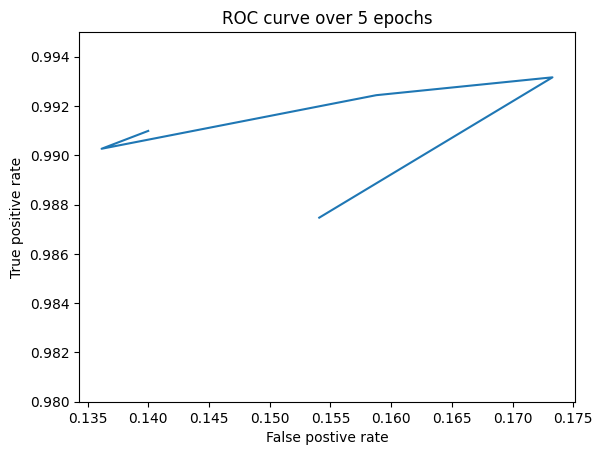

In [27]:
#plot ROC curve for training
plt.plot(fpr, tpr)
plt.title("ROC curve over 5 epochs")
plt.xlabel("False postive rate")
plt.ylabel("True positive rate")
plt.ylim(.98,.995)

(0.98, 0.995)

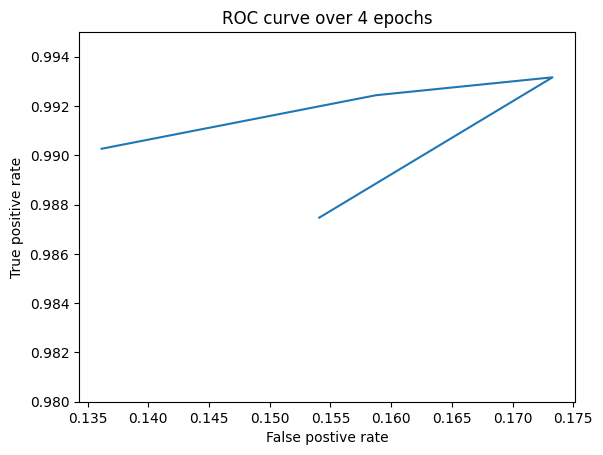

In [42]:
fpr1 = fpr[0:4]
tpr1 = tpr[0:4]

plt.plot(fpr1, tpr1)
plt.title("ROC curve over 4 epochs")
plt.xlabel("False postive rate")
plt.ylabel("True positive rate")
plt.ylim(.98,.995)
